In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
pip install fuzzywuzzy

In [41]:
import numpy as np
import pandas as pd
import xgboost as xgb
import datetime
import operator
from sklearn.model_selection import train_test_split
from collections import Counter
import nltk
nltk.download('stopwords')
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from pylab import plot, show, subplot, specgram, imshow, savefig
from fuzzywuzzy import fuzz
from tqdm import tqdm_notebook
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from nltk import word_tokenize
stop_words = stopwords.words('english')
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import gensim
from gensim.models import Word2Vec
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/Kaggle/GoogleNews-vectors-negative300.bin.gz', binary=True)


RS = 12357
ROUNDS = 500

print("Started")
np.random.seed(RS)
input_folder = '/content/drive/My Drive/Kaggle/'

def train_xgb(X, y, params):
	print("Will train XGB for {} rounds, RandomSeed: {}".format(ROUNDS, RS))
	x, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RS)

	xg_train = xgb.DMatrix(x, label=y_train)
	xg_val = xgb.DMatrix(X_val, label=y_val)

	watchlist  = [(xg_train,'train'), (xg_val,'eval')]
	return xgb.train(params, xg_train, ROUNDS, watchlist)

def predict_xgb(clr, X_test):
	return clr.predict(xgb.DMatrix(X_test))

def create_feature_map(features):
	outfile = open('xgb.fmap', 'w')
	i = 0
	for feat in features:
		outfile.write('{0}\t{1}\tq\n'.format(i, feat))
		i = i + 1
	outfile.close()

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
	return 0 if count < min_count else 1 / (count + eps)

def word_shares(row):
	q1 = set(str(row['sent1']).lower().split())
	q1words = q1.difference(stops)
	if len(q1words) == 0:
		return '0:0:0:0:0'

	q2 = set(str(row['sent2']).lower().split())
	q2words = q2.difference(stops)
	if len(q2words) == 0:
		return '0:0:0:0:0'

	q1stops = q1.intersection(stops)
	q2stops = q2.intersection(stops)

	shared_words = q1words.intersection(q2words)
	shared_weights = [weights.get(w, 0) for w in shared_words]
	total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
	
	R1 = np.sum(shared_weights) / np.sum(total_weights) #tfidf share
	R2 = len(shared_words) / (len(q1words) + len(q2words)) #count share
	R31 = len(q1stops) / len(q1words) #stops in q1
	R32 = len(q2stops) / len(q2words) #stops in q2
	return '{}:{}:{}:{}:{}'.format(R1, R2, len(shared_words), R31, R32)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Started


In [42]:
df_train = pd.read_csv(input_folder + 'train.csv')
df_test  = pd.read_csv(input_folder + 'test.csv')
print("Original data: X_train: {}, X_test: {}".format(df_train.shape, df_test.shape))

print("Features processing, be patient...")

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
  return 0 if count < min_count else 1 / (count + eps)

train_qs = pd.Series(df_train['sent1'].tolist() + df_train['sent2'].tolist()).astype(str)
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

stops = set(stopwords.words("english"))
	

df = pd.concat([df_train, df_test])
df['word_shares'] = df.apply(word_shares, axis=1, raw=True)

x = pd.DataFrame()

x['word_match']       = df['word_shares'].apply(lambda x: float(x.split(':')[0]))
x['tfidf_word_match'] = df['word_shares'].apply(lambda x: float(x.split(':')[1]))
#x['shared_count']     = df['word_shares'].apply(lambda x: float(x.split(':')[2]))

x['stops1_ratio']     = df['word_shares'].apply(lambda x: float(x.split(':')[3]))
x['stops2_ratio']     = df['word_shares'].apply(lambda x: float(x.split(':')[4]))
x['diff_stops_r']     = x['stops1_ratio'] - x['stops2_ratio']

x['len_q1'] = df['sent1'].apply(lambda x: len(str(x)))
x['len_q2'] = df['sent2'].apply(lambda x: len(str(x)))
x['diff_len'] = x['len_q1'] - x['len_q2']

x['len_char_q1'] = df['sent1'].apply(lambda x: len(str(x).replace(' ', '')))
x['len_char_q2'] = df['sent2'].apply(lambda x: len(str(x).replace(' ', '')))
x['diff_len_char'] = x['len_char_q1'] - x['len_char_q2']

x['len_word_q1'] = df['sent1'].apply(lambda x: len(str(x).split()))
x['len_word_q2'] = df['sent2'].apply(lambda x: len(str(x).split()))
x['diff_len_word'] = x['len_word_q1'] - x['len_word_q2']

x['avg_world_len1'] = x['len_char_q1'] / x['len_word_q1']
x['avg_world_len2'] = x['len_char_q2'] / x['len_word_q2']
x['diff_avg_word'] = x['avg_world_len1'] - x['avg_world_len2']



def wmd(q1, q2):
  q1 = str(q1).lower().split()
  q2 = str(q2).lower().split()
  stop_words = stopwords.words('english')
  q1 = [w for w in q1 if w not in stop_words]
  q2 = [w for w in q2 if w not in stop_words]
  return model.wmdistance(q1, q2)
def norm_wmd(q1, q2):
  q1 = str(q1).lower().split()
  q2 = str(q2).lower().split()
  stop_words = stopwords.words('english')
  q1 = [w for w in q1 if w not in stop_words]
  q2 = [w for w in q2 if w not in stop_words]
  return norm_model.wmdistance(q1, q2)
def sent2vec(s):
  words = str(s).lower()
  words = word_tokenize(words)
  words = [w for w in words if not w in stop_words]
  words = [w for w in words if w.isalpha()]
  M = []
  for w in words:
    try:
      M.append(model[w])
    except:
      continue
  M = np.array(M)
  v = M.sum(axis=0)
  return v / np.sqrt((v ** 2).sum())

question1_vectors = np.zeros((df.shape[0], 300))
for i, q in enumerate(tqdm_notebook(df.sent1.values)):
  question1_vectors[i, :] = sent2vec(q)
    
question2_vectors  = np.zeros((df.shape[0], 300))
for i, q in enumerate(tqdm_notebook(df.sent2.values)):
  question2_vectors[i, :] = sent2vec(q)

x['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
x['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
print('done cityblock_distance')
x['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
x['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
print('done canberra_distance')
#x['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
x['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
print('done minkowski_distance ')
x['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
x['skew_q1vec'] = [skew(x) for x in np.nan_to_num(question1_vectors)]
print('done skew_q1vec')
x['skew_q2vec'] = [skew(x) for x in np.nan_to_num(question2_vectors)]
x['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(question1_vectors)]
print('done kur_q1vec')
x['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(question2_vectors)]
print('done vec feature')

model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/Kaggle/GoogleNews-vectors-negative300.bin.gz', binary=True)
x['wmd'] = df.apply(lambda x: wmd(x['sent1'], x['sent2']), axis=1)
print('done wmd')
norm_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/Kaggle/GoogleNews-vectors-negative300.bin.gz', binary=True)
norm_model.init_sims(replace=True)
x['norm_wmd'] = df.apply(lambda x: norm_wmd(x['sent1'], x['sent2']), axis=1)
print('done norm_wmd')


x['exactly_same'] = (df['sent1'] == df['sent2']).astype(int)
x['duplicated'] = df.duplicated(['sent1','sent2']).astype(int)
x['common_words'] = df.apply(lambda x: len(set(str(x['sent1']).lower().split()).intersection(set(str(x['sent2']).lower().split()))), axis=1)
x['fuzz_ratio'] = df.apply(lambda x: fuzz.ratio(str(x['sent1']), str(x['sent2'])), axis=1)
print('done fuzz_ratio')
x['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x['sent1']), str(x['sent2'])), axis=1)
print('done fuzz_partial_ratio')
x['fuzz_partial_token_set_ratio'] = df.apply(lambda x: fuzz.partial_token_set_ratio(str(x['sent1']), str(x['sent2'])), axis=1)
print('done fuzz_partial_token_set_ratio')
x['fuzz_partial_token_sort_ratio'] = df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['sent1']), str(x['sent2'])), axis=1)
print('done fuzz_partial_token_sort_ratio')
x['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(str(x['sent1']), str(x['sent2'])), axis=1)
print('done fuzz_token_set_ratio')
x['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(str(x['sent1']), str(x['sent2'])), axis=1)
print('done fuzz_token_sort_ratio')
#... YOUR FEATURES HERE ...


Original data: X_train: (129156, 4), X_test: (14350, 3)
Features processing, be patient...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in double_scalars


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in double_scalars


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


done cityblock_distance
done canberra_distance
done minkowski_distance 


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:1178: RuntimeWarning: invalid value encountered in double_scalars
  return l1_diff.sum() / l1_sum.sum()


done skew_q1vec
done kur_q1vec
done vec feature


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


done wmd
done norm_wmd
done fuzz_ratio
done fuzz_token_set_ratio


In [0]:
#Low Importance Features(Don't run this)
x['tfidf_word_match'] = df['word_shares'].apply(lambda x: float(x.split(':')[1]))
x['common_words'] = df.apply(lambda x: len(set(str(x['sent1']).lower().split()).intersection(set(str(x['sent2']).lower().split()))), axis=1)
x['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(str(x['sent1']), str(x['sent2'])), axis=1)
print('done fuzz_token_sort_ratio')
x['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x['sent1']), str(x['sent2'])), axis=1)
print('done fuzz_partial_ratio')
x['fuzz_partial_token_set_ratio'] = df.apply(lambda x: fuzz.partial_token_set_ratio(str(x['sent1']), str(x['sent2'])), axis=1)
print('done fuzz_partial_token_set_ratio')
x['fuzz_partial_token_sort_ratio'] = df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['sent1']), str(x['sent2'])), axis=1)
print('done fuzz_partial_token_sort_ratio')
x['len_char_q1'] = df['sent1'].apply(lambda x: len(str(x).replace(' ', '')))
x['len_char_q2'] = df['sent2'].apply(lambda x: len(str(x).replace(' ', '')))
x['diff_len_char'] = x['len_char_q1'] - x['len_char_q2']

x['len_word_q1'] = df['sent1'].apply(lambda x: len(str(x).split()))
x['len_word_q2'] = df['sent2'].apply(lambda x: len(str(x).split()))
x['diff_len_word'] = x['len_word_q1'] - x['len_word_q2']

In [58]:
RS = 12357
ROUNDS = 500
eta = 0.15
max_depth = 15
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = eta
params['max_depth'] = max_depth
params['silent'] = 1
params['seed'] = RS

feature_names = list(x.columns.values)
create_feature_map(feature_names)
print("Features: {}".format(feature_names))

x_train = x[:df_train.shape[0]]
x_test  = x[df_train.shape[0]:]
y_train = df_train['same_source'].values

print("Training data: X_train: {}, Y_train: {}, X_test: {}".format(x_train.shape, len(y_train), x_test.shape))
clr = train_xgb(x_train, y_train, params)
preds = predict_xgb(clr, x_test)

print("Writing output...")
sub = pd.DataFrame()
sub['id'] = df_test['id']
sub['same_source'] = preds
sub.to_csv(input_folder + "xgb_seed{}_n{}.csv".format(eta, max_depth), index=False)

Features: ['word_match', 'stops1_ratio', 'stops2_ratio', 'diff_stops_r', 'len_q1', 'len_q2', 'diff_len', 'avg_world_len1', 'avg_world_len2', 'diff_avg_word', 'cosine_distance', 'cityblock_distance', 'jaccard_distance', 'canberra_distance', 'minkowski_distance', 'braycurtis_distance', 'skew_q1vec', 'skew_q2vec', 'kur_q1vec', 'kur_q2vec', 'wmd', 'norm_wmd', 'exactly_same', 'duplicated', 'fuzz_ratio', 'fuzz_token_set_ratio', 'tfidf_word_match', 'common_words', 'fuzz_token_sort_ratio', 'fuzz_partial_ratio', 'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio', 'len_char_q1', 'len_char_q2', 'diff_len_char', 'len_word_q1', 'len_word_q2', 'diff_len_word']
Training data: X_train: (129156, 38), Y_train: 129156, X_test: (14350, 38)
Will train XGB for 500 rounds, RandomSeed: 12357
[0]	train-logloss:0.634855	eval-logloss:0.659357
[1]	train-logloss:0.58788	eval-logloss:0.63388
[2]	train-logloss:0.549225	eval-logloss:0.61525
[3]	train-logloss:0.515573	eval-logloss:0.600553
[4]	train-loglo

Features importances...


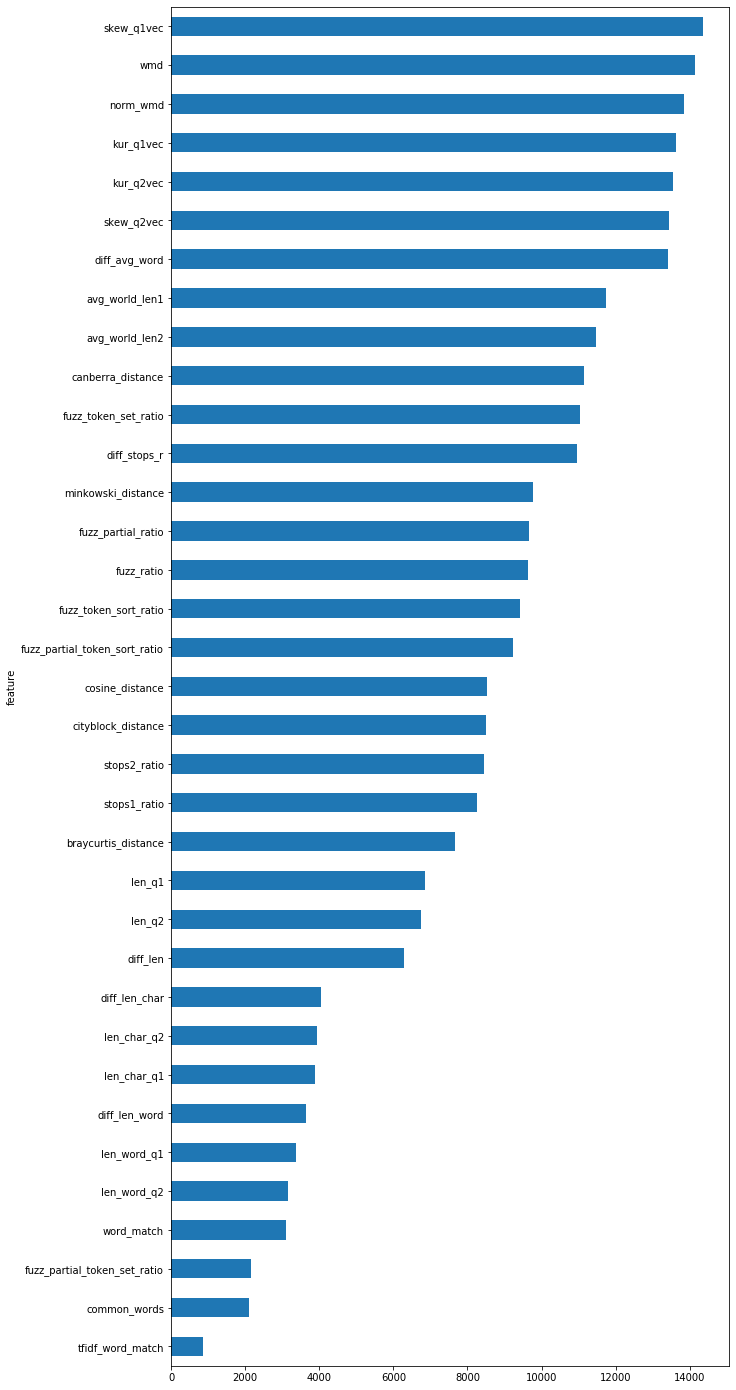

In [59]:
print("Features importances...")
importance = clr.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
ft = pd.DataFrame(importance, columns=['feature', 'fscore'])

ft.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 25))
plt.gcf().savefig('features_importance.png')

Analyze Model Correctness

In [0]:
preds = predict_xgb(clr, x_train)
df_report = pd.DataFrame()
df_report['id'] = df_train['id']
df_report['sent1'] = df_train['sent1']
df_report['sent2'] = df_train['sent2']
df_report['pred'] = preds
df_report['y'] = df_train['same_source']
df_report['diff'] = abs(df_report['y'] - df_report['pred'])

In [0]:
df_report.sort_values(by=['diff'],inplace=True)

In [0]:
df_report

Analyze Feature Separation

In [0]:
report = x_train.copy()
report['y'] = y_train
grp = report.groupby(by=['y']).mean()
grp

,word_match,tfidf_word_match,shared_count,stops1_ratio,stops2_ratio,diff_stops_r,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,diff_len_char,len_word_q1,len_word_q2,diff_len_word,avg_world_len1,avg_world_len2,diff_avg_word,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec,wmd,norm_wmd,exactly_same,duplicated,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
y,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.002473,0.003142,0.065163,0.565399,0.565291,0.000108,116.766752,117.349376,-0.582624,98.253336,98.753964,-0.500628,19.457087,19.536526,-0.079439,5.111787,5.119186,-0.007399,0.711284,16.425588,0.998372,194.034727,1.186535,0.534953,0.741947,0.035005,0.034684,-0.095241,-0.096900,inf,inf,0.000016,0.000000,1.690196,22.056529,31.795319,86.972565,36.412571,29.823095,27.509277
1,0.015646,0.015585,0.355239,0.564503,0.565140,-0.000637,116.886543,116.893210,-0.006668,98.357745,98.349716,0.008029,19.473569,19.489426,-0.015857,5.119765,5.111591,0.008175,0.593810,14.943808,0.999319,183.509916,1.079283,0.486586,0.649355,0.034319,0.035436,-0.094661,-0.095896,inf,inf,0.000093,0.000062,2.144073,23.809703,33.754088,90.606442,39.129144,34.793397,30.857892
